---
title: BANA 6040 Final Project - Jesse Slomowitz
---
## Executive Summary

**Business Question:** Are our promotion-heavy customers high-value "smart shoppers" who drive revenue, or low-margin "cherry-pickers" who erode profits?

**Key Findings:**

1. **The Promotion Paradox:** Promotion-heavy customers spend 19% more annually ($2,092 vs $1,757) but buy 33% cheaper items ($0.92 vs $1.37 per unit). When controlled for spending level, promo-light high-spenders actually have 6% higher basket values ($45.10 vs $42.26), revealing a classic Simpson's Paradox.

2. **Margin Killers Outnumber Smart Shoppers 2:1:** We identified 238 "smart shoppers" (9.6%) who combine high promotion usage with high spending. However, they're outnumbered by 529 "margin killers" (21.4%) who use promotions heavily but maintain low basket values ($28.48).

3. **Missing the Affluent Customer:** Only 9.1% of 250K+ income households are promo-heavy, compared to 46.4% of 50-74K households. We're successfully attracting budget-constrained necessity shoppers but missing affluent discretionary spenders entirely.

4. **Highest Value Customers Don't Need Promotions:** The "Untapped Potential" segment (380 households, 15.4%) maintains the highest basket values ($45.10) with minimal promotion usage, proving that high value exists without heavy discounting.

**Recommendation:**

**Reduce overall promotional spending by 25-30% while shifting to segment-specific strategies:**
- PROTECT high-value, low-promo customers (offer convenience, not discounts)
- REWARD smart shoppers selectively (personalized, premium-focused offers)
- REDUCE subsidies to margin killers (basket minimums, category restrictions)
- ATTRACT missing affluent demographics (experience over price)

**Expected Impact:** ~$230,000 annual savings in promotional costs while maintaining or improving revenue from high-value segments. Pilot approach manages risk with 90-day test before full rollout.

**Strategic Shift:** From volume-focused (attract everyone) to value-focused (attract the right customers).



## 1. Business Problem & Approach

### Why This Matters to Regork

Promotions cost money. Every discount dollar represents potential margin erosion. But promotions 
also drive traffic, build loyalty, and can attract high-value customers. The question is: **which 
customers are we attracting with our promotions?**

There are two competing hypotheses:

**Hypothesis A: "Margin Killers"**  
Promotion-heavy households are price-sensitive cherry-pickers who:
- Only shop during sales
- Buy low-margin items
- Have small basket sizes
- Would defect to competitors for better deals

**Hypothesis B: "Smart Shoppers"**  
Promotion-heavy households are savvy, high-value customers who:
- Use promotions strategically but still spend significantly
- Buy premium products at a discount
- Have large basket sizes
- Are loyal if we keep engaging them with targeted offers

### Our Approach

We will analyze 1.47M transactions across 801 households to:

1. **Define promotion intensity** using discount usage and coupon redemptions
2. **Segment households** into a 2×2 matrix:
   - Promotion usage (heavy vs. light)
   - Spending level (high vs. low)
3. **Identify "smart shoppers"** (high promotion + high spending)
4. **Analyze demographic patterns** (income, kids, household size)
5. **Recommend action** based on which hypothesis the data supports

### Data Sources

We use the Complete Journey dataset (via `completejourney_py`):

- **transactions** (1.47M records): Item-level purchases with discounts
- **demographics** (801 households): Age, income, kids, household composition
- **coupon_redemptions** (2.3K records): Specific coupon usage events
- **coupons** (116K records): Coupon metadata



In [52]:
import warnings
import os

warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
os.environ['PYTHONWARNINGS'] = 'ignore'

import os
os.environ['PYTHONWARNINGS'] = 'ignore'

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from completejourney_py import get_data
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', 120)
pd.set_option('display.float_format', '{:.2f}'.format)

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10




## 2. Data Loading & Initial Inspection


In [53]:

all_data = get_data()

transactions = all_data["transactions"]
demographics = all_data["demographics"]
coupons = all_data["coupons"]
coupon_redemptions = all_data["coupon_redemptions"]

data_summary = pd.DataFrame({
    'Dataset': ['Transactions', 'Demographics', 'Coupon Redemptions', 'Coupons'],
    'Count': [f'{len(transactions):,}', f'{len(demographics):,}', f'{len(coupon_redemptions):,}', f'{len(coupons):,}']
})
display(data_summary.set_index('Dataset'))



,Count
Dataset,
Transactions,"1,469,307"
Demographics,801
Coupon Redemptions,"2,102"
Coupons,"116,204"


In [54]:
print("TRANSACTIONS DATASET")
display(transactions.head())
print(f"\nDate range: {transactions['transaction_timestamp'].min()} to {transactions['transaction_timestamp'].max()}")



TRANSACTIONS DATASET


,household_id,store_id,basket_id,product_id,quantity,sales_value,retail_disc,coupon_disc,coupon_match_disc,week,transaction_timestamp
0,900,330,31198570044,1095275,1,0.50,0.00,0.00,0.00,1,2017-01-01 11:53:26
1,900,330,31198570047,9878513,1,0.99,0.10,0.00,0.00,1,2017-01-01 12:10:28
2,1228,406,31198655051,1041453,1,1.43,0.15,0.00,0.00,1,2017-01-01 12:26:30
3,906,319,31198705046,1020156,1,1.50,0.29,0.00,0.00,1,2017-01-01 12:30:27
4,906,319,31198705046,1053875,2,2.78,0.80,0.00,0.00,1,2017-01-01 12:30:27



Date range: 2017-01-01 11:53:26 to 2018-01-01 04:01:20


In [55]:
display(demographics.head(10))

,household_id,age,income,home_ownership,marital_status,household_size,household_comp,kids_count
0,1,65+,35-49K,Homeowner,Married,2,2 Adults No Kids,0
1,1001,45-54,50-74K,Homeowner,Unmarried,1,1 Adult No Kids,0
2,1003,35-44,25-34K,None,Unmarried,1,1 Adult No Kids,0
3,1004,25-34,15-24K,None,Unmarried,1,1 Adult No Kids,0
4,101,45-54,Under 15K,Homeowner,Married,4,2 Adults Kids,2
5,1012,35-44,35-49K,None,Married,5+,2 Adults Kids,3+
6,1014,45-54,15-24K,None,Married,4,2 Adults Kids,2
7,1015,45-54,50-74K,Homeowner,Unmarried,1,1 Adult No Kids,0
8,1018,45-54,35-49K,Homeowner,Married,5+,2 Adults Kids,3+
9,1020,45-54,25-34K,Homeowner,Married,2,2 Adults No Kids,0


In [56]:
print("COUPON REDEMPTIONS DATASET")
display(coupon_redemptions.head())

COUPON REDEMPTIONS DATASET


,household_id,coupon_upc,campaign_id,redemption_date
0,1029,51380041013,26,2017-01-01
1,1029,51380041313,26,2017-01-01
2,165,53377610033,26,2017-01-03
3,712,51380041013,26,2017-01-07
4,712,54300016033,26,2017-01-07


## 3. Define Promotion Usage Metrics

We measure promotion intensity using two complementary metrics:

### 3.1 Discount Usage
From `transactions`, we calculate what % of items were purchased with **any** discount:
- `retail_disc` > 0 (sale price)
- `coupon_disc` > 0 (manufacturer coupon)
- `coupon_match_disc` > 0 (store matches competitor coupon)

### 3.2 Coupon Redemptions
From `coupon_redemptions`, we count how many coupons each household redeemed
and normalize by purchase volume to get "coupons per 100 items purchased"


In [57]:

discount_cols = ['retail_disc', 'coupon_disc', 'coupon_match_disc']

missing_cols = [c for c in discount_cols if c not in transactions.columns]
if missing_cols:
    discount_cols = [c for c in discount_cols if c in transactions.columns]


if discount_cols:
    transactions['has_discount'] = (transactions[discount_cols] > 0).any(axis=1)
else:
    print("⚠️ No discount columns found - assuming no discounts")
    transactions['has_discount'] = False

total_transactions = len(transactions)
discounted_transactions = transactions['has_discount'].sum()
discount_rate = discounted_transactions / total_transactions

summary_df = pd.DataFrame({
    'Metric': ['Total Transactions', 'Transactions with Discount', 'Overall Discount Rate'],
    'Value': [f'{total_transactions:,}', f'{discounted_transactions:,}', f'{discount_rate:.1%}']
})
display(summary_df.set_index('Metric'))

print("\nSample transactions with discounts:")
display(transactions[transactions['has_discount']][
    ['household_id', 'sales_value', 'retail_disc', 'coupon_disc', 'coupon_match_disc']
].head(10))



,Value
Metric,
Total Transactions,"1,469,307"
Transactions with Discount,"746,192"
Overall Discount Rate,50.8%



Sample transactions with discounts:


,household_id,sales_value,retail_disc,coupon_disc,coupon_match_disc
1,900,0.99,0.10,0.00,0.00
2,1228,1.43,0.15,0.00,0.00
3,906,1.50,0.29,0.00,0.00
4,906,2.78,0.80,0.00,0.00
5,906,5.49,0.50,0.00,0.00
6,906,1.50,0.29,0.00,0.00
7,1058,1.88,0.21,0.00,0.00
8,1058,1.50,1.29,0.00,0.00
19,1419,1.00,0.29,0.00,0.00
22,1873,1.50,0.29,0.00,0.00


In [58]:

discount_usage = (
    transactions
    .groupby('household_id')
    .agg(
        total_items=('has_discount', 'size'),
        discounted_items=('has_discount', 'sum'),
        total_sales=('sales_value', 'sum')
    )
    .reset_index()
)

discount_usage['discount_share'] = (
    discount_usage['discounted_items'] / discount_usage['total_items']
)

print("\nDiscount share distribution:")
display(discount_usage['discount_share'].describe())

print("\nTop 10 households by discount usage:")
display(discount_usage.nlargest(10, 'discount_share')[
    ['household_id', 'total_items', 'discounted_items', 'discount_share']
])




Discount share distribution:


count   2469.00
mean       0.50
std        0.11
min        0.00
25%        0.43
50%        0.50
75%        0.57
max        1.00
Name: discount_share, dtype: float64


Top 10 households by discount usage:


,household_id,total_items,discounted_items,discount_share
228,231,2,2,1.00
237,240,1,1,1.00
269,272,1,1,1.00
348,352,1,1,1.00
959,967,1,1,1.00
1166,1176,1,1,1.00
1387,1400,5,5,1.00
2087,2111,362,325,0.90
1657,1674,9,8,0.89
1328,1341,98,87,0.89


In [59]:

coupon_usage = (
    coupon_redemptions
    .groupby('household_id')
    .size()
    .rename('num_coupons_redeemed')
    .reset_index()
)

coupon_summary = pd.DataFrame({
    'Metric': ['Households with Coupons', 'Total Coupons Redeemed', 'Average per Household'],
    'Value': [f'{len(coupon_usage):,}', f'{coupon_usage["num_coupons_redeemed"].sum():,}', f'{coupon_usage["num_coupons_redeemed"].mean():.1f}']
})
display(coupon_summary.set_index('Metric'))

print("\nTop 10 coupon users:")
display(coupon_usage.nlargest(10, 'num_coupons_redeemed'))



,Value
Metric,
Households with Coupons,410
Total Coupons Redeemed,"2,102"
Average per Household,5.1



Top 10 coupon users:


,household_id,num_coupons_redeemed
45,256,30
65,367,30
154,931,29
406,2489,27
290,1823,25
11,67,24
387,2400,23
397,2451,23
101,588,22
252,1591,22


## 4. Define Spending Behavior Metrics

To assess whether promotion-heavy households are high-value or low-value, we calculate:

- **Total annual spending** (`total_sales`)
- **Number of shopping trips** (`num_trips` = distinct baskets)
- **Average basket value** (total_sales / num_trips)
- **Average price per unit** (total_sales / total_quantity) - if quantity data available

These metrics help us distinguish between:
- High-value customers (large baskets, expensive items)
- Low-value customers (small baskets, cheap items)


In [60]:

qty_col = None
for candidate in ['quantity', 'QUANTITY', 'purchase_quantity']:
    if candidate in transactions.columns:
        qty_col = candidate
        break

agg_dict = {
    'sales_value': 'sum',
    'basket_id': pd.Series.nunique,
}

if qty_col:
    agg_dict[qty_col] = 'sum'
else:
    print("⚠️ No quantity column found - cannot calculate avg price per unit")

household_spend = (
    transactions
    .groupby('household_id')
    .agg(agg_dict)
    .rename(columns={
        'sales_value': 'total_sales',
        'basket_id': 'num_trips',
    })
    .reset_index()
)

household_spend['avg_basket_value'] = (
    household_spend['total_sales'] / household_spend['num_trips']
)

if qty_col:
    household_spend.rename(columns={qty_col: 'total_quantity'}, inplace=True)
    household_spend['avg_price_per_unit'] = (
        household_spend['total_sales'] / household_spend['total_quantity'].replace(0, np.nan)
    )
    
    
    zero_qty_count = (household_spend['total_quantity'] == 0).sum()
    if zero_qty_count > 0:
        print(f"  ⚠️ Warning: {zero_qty_count} households have zero total quantity")


print("\nSpending behavior summary:")
display(household_spend[['total_sales', 'num_trips', 'avg_basket_value']].describe())

if 'avg_price_per_unit' in household_spend.columns:
    print("\nAverage price per unit:")
    display(household_spend['avg_price_per_unit'].describe())




Spending behavior summary:


,total_sales,num_trips,avg_basket_value
count,2469.00,2469.00,2469.00
mean,1861.50,63.12,31.86
std,2022.53,69.85,20.72
min,2.00,1.00,2.00
25%,468.85,20.00,17.58
50%,1210.02,43.00,27.30
75%,2536.15,83.00,40.88
max,24879.75,780.00,188.34



Average price per unit:


count   2469.00
mean       1.23
std        1.33
min        0.00
25%        0.03
50%        1.38
75%        2.22
max       25.00
Name: avg_price_per_unit, dtype: float64

In [61]:
print("\nTop 10 households by total spending:")
display(household_spend.nlargest(10, 'total_sales')[
    ['household_id', 'total_sales', 'num_trips', 'avg_basket_value']
])




Top 10 households by total spending:


,household_id,total_sales,num_trips,avg_basket_value
1015,1023,24879.75,375,66.35
1593,1609,16581.36,245,67.68
1440,1453,13376.23,502,26.65
2294,2322,13187.54,178,74.09
1417,1430,12849.31,202,63.61
1101,1111,12368.36,162,76.35
394,400,11801.64,191,61.79
699,707,11491.56,295,38.95
1636,1653,11190.39,338,33.11
1475,1489,10963.69,348,31.50


## 5. Combine Data: Promotions + Spending + Demographics

Now we create a master household-level dataset that includes:
- Promotion usage (discount share + coupon redemptions)
- Spending behavior (total sales, basket value, item prices)
- Demographics (age, income, kids, household size)

This unified dataset enables us to answer our key questions about smart shoppers.


In [62]:

households = (
    household_spend
    .merge(discount_usage[['household_id', 'discount_share', 'discounted_items', 'total_items']], 
           on='household_id', how='left', suffixes=('', '_disc'))
    .merge(coupon_usage, on='household_id', how='left')
    .merge(demographics, on='household_id', how='left')
)

households['num_coupons_redeemed'] = households['num_coupons_redeemed'].fillna(0)
households['discount_share'] = households['discount_share'].fillna(0)


print("\nMerge quality check:")
household_data_df = pd.DataFrame({
    'Data Type': [
        'Households with Spending Data',
        'Households with Demographic Data',
        'Households with Discount Data',
        'Households with Coupon Redemptions'
    ],
    'Count': [
        f"{household_spend['household_id'].nunique():,}",
        f"{households['age'].notna().sum():,}",
        f"{households['discount_share'].notna().sum():,}",
        f"{(households['num_coupons_redeemed'] > 0).sum():,}"
    ]
})
display(household_data_df.set_index('Data Type'))




Merge quality check:


,Count
Data Type,
Households with Spending Data,"2,469"
Households with Demographic Data,801
Households with Discount Data,"2,469"
Households with Coupon Redemptions,410


In [63]:
print("\nSample of unified household data:")
display(households[[
    'household_id', 'total_sales', 'avg_basket_value', 'discount_share', 
    'num_coupons_redeemed', 'income', 'kids_count', 'household_comp'
]].head(15))




Sample of unified household data:


,household_id,total_sales,avg_basket_value,discount_share,num_coupons_redeemed,income,kids_count,household_comp
0,1,2415.56,47.36,0.47,5.00,35-49K,0,2 Adults No Kids
1,2,1024.12,51.21,0.46,0.00,NaN,NaN,NaN
2,3,1026.63,51.33,0.57,0.00,NaN,NaN,NaN
3,4,442.14,24.56,0.48,0.00,NaN,NaN,NaN
4,5,299.67,14.98,0.51,0.00,NaN,NaN,NaN
5,6,3464.87,22.35,0.37,0.00,NaN,NaN,NaN
6,7,1952.37,61.01,0.44,0.00,50-74K,0,2 Adults No Kids
7,8,3080.81,47.40,0.50,1.00,25-34K,1,2 Adults Kids
8,9,620.73,56.43,0.57,0.00,NaN,NaN,NaN
9,10,29.96,29.96,0.50,0.00,NaN,NaN,NaN


In [64]:

households['coupons_per_100_items'] = (
    households['num_coupons_redeemed'] / households['total_items'] * 100
)

print("\nDistribution:")
display(households['coupons_per_100_items'].describe())




Distribution:


count   2469.00
mean       0.08
std        0.25
min        0.00
25%        0.00
50%        0.00
75%        0.00
max        3.24
Name: coupons_per_100_items, dtype: float64

## 6. Define "Promotion-Heavy" vs "Promotion-Light" Households

We need a transparent, business-friendly way to classify households by promotion intensity.

### Our Approach: Independent Thresholds

Instead of creating an arbitrary weighted score, we use the natural distribution of the data:

- **Discount-heavy**: Top 25% of `discount_share` (% of items bought on sale)
- **Coupon-heavy**: Top 25% of `coupons_per_100_items` (redemption rate)

A household is classified as **"promo_heavy"** if they are in the top quartile of 
**either metric** (or both). This captures:
- Heavy sale shoppers
- Heavy coupon users  
- Households who are both

Everyone else is **"promo_light"**.

This mirrors how retailers think about promotion engagement and is easy to explain to executives.


In [65]:

print("DEFINING PROMOTION SEGMENTS")


DEFINING PROMOTION SEGMENTS


In [66]:
disc_threshold = households["discount_share"].quantile(0.75)
coupon_threshold = households["coupons_per_100_items"].quantile(
    0.50
)

print("\nThreshold values:")
threshold_df = pd.DataFrame({
    'Metric': ['Discount Share (75th percentile)', 'Coupon Usage (50th percentile)'],
    'Threshold': [f'{disc_threshold:.1%}', f'{coupon_threshold:.2f}']
})
display(threshold_df.set_index('Metric'))



Threshold values:


,Threshold
Metric,
Discount Share (75th percentile),56.9%
Coupon Usage (50th percentile),0.00


In [67]:
extreme_disc_threshold = households["discount_share"].quantile(0.90)
extreme_coupon_threshold = households["coupons_per_100_items"].quantile(0.90)

households["is_high_discount"] = households["discount_share"] >= disc_threshold
households["is_high_coupon"] = households["coupons_per_100_items"] >= coupon_threshold
households["is_extreme_disc"] = households["discount_share"] >= extreme_disc_threshold
households["is_extreme_coupon"] = (
    households["coupons_per_100_items"] >= extreme_coupon_threshold
)


In [68]:
households["promo_heavy_flag"] = (
    (
        households["is_high_discount"] & households["is_high_coupon"]
    )
    | households["is_extreme_disc"]
    | households["is_extreme_coupon"]
)


In [69]:
households["promo_segment"] = np.where(
    households["promo_heavy_flag"], "promo_heavy", "promo_light"
)


In [70]:
segment_counts = households["promo_segment"].value_counts()
for segment, count in segment_counts.items():
    pct = count / len(households) * 100


In [71]:
if "promo_heavy" in segment_counts.index:
    promo_heavy_hh = households[households["promo_segment"] == "promo_heavy"]

    both_high = (
        promo_heavy_hh["is_high_discount"] & promo_heavy_hh["is_high_coupon"]
    ).sum()
    extreme_disc = promo_heavy_hh["is_extreme_disc"].sum()
    extreme_coup = promo_heavy_hh["is_extreme_coupon"].sum()

    promo_qual_df = pd.DataFrame({
        'Qualification Type': [
            'High Discount + Some Coupons',
            'Extreme Discount Users (Top 10%)',
            'Extreme Coupon Users (Top 10%)'
        ],
        'Count': [f'{both_high:,}', f'{extreme_disc:,}', f'{extreme_coup:,}']
    })
    print("\nPromo-heavy qualification:")
    display(promo_qual_df.set_index('Qualification Type'))



Promo-heavy qualification:


,Count
Qualification Type,
High Discount + Some Coupons,618
Extreme Discount Users (Top 10%),251
Extreme Coupon Users (Top 10%),247


## 7. Compare Spending: Promo-Heavy vs. Promo-Light

**Critical Question:** Do promotion-heavy households spend MORE or LESS than promotion-light households?

- If MORE → They're "smart shoppers" worth retaining
- If LESS → They might be "margin killers"

We'll compare:
- Total annual spending
- Average basket value
- Average price per unit (if available)


In [72]:

promo_summary = (
    households
    .groupby('promo_segment')
    .agg(
        num_households=('household_id', 'nunique'),
        mean_total_sales=('total_sales', 'mean'),
        median_total_sales=('total_sales', 'median'),
        mean_num_trips=('num_trips', 'mean'),
        mean_avg_basket=('avg_basket_value', 'mean'),
        median_avg_basket=('avg_basket_value', 'median'),
    )
)

if 'avg_price_per_unit' in households.columns:
    promo_summary['mean_avg_price_unit'] = (
        households.groupby('promo_segment')['avg_price_per_unit'].mean()
    )
    promo_summary['median_avg_price_unit'] = (
        households.groupby('promo_segment')['avg_price_per_unit'].median()
    )

promo_summary = promo_summary.round(2)

print("\n" + "=" * 80)
print("SPENDING COMPARISON: Promo-Heavy vs. Promo-Light")
display(promo_summary)




SPENDING COMPARISON: Promo-Heavy vs. Promo-Light


,num_households,mean_total_sales,median_total_sales,mean_num_trips,mean_avg_basket,median_avg_basket,mean_avg_price_unit,median_avg_price_unit
promo_segment,,,,,,,,
promo_heavy,767,2092.36,1475.98,70.71,32.75,28.40,0.92,0.13
promo_light,1702,1757.46,1126.78,59.70,31.45,26.72,1.37,1.65


In [73]:

print("\n" + "=" * 80)
print("STATISTICAL SIGNIFICANCE TESTS")

heavy_baskets = households[households['promo_segment'] == 'promo_heavy']['avg_basket_value'].dropna()
light_baskets = households[households['promo_segment'] == 'promo_light']['avg_basket_value'].dropna()

t_stat_basket, p_value_basket = stats.ttest_ind(heavy_baskets, light_baskets)

print("\n1. Average Basket Value:")
ttest_df = pd.DataFrame({
    'Metric': [
        'Promo-Heavy Mean',
        'Promo-Light Mean',
        'Difference',
        'T-Statistic',
        'P-Value'
    ],
    'Value': [
        f'${heavy_baskets.mean():.2f}',
        f'${light_baskets.mean():.2f}',
        f'${heavy_baskets.mean() - light_baskets.mean():.2f}',
        f'{t_stat_basket:.4f}',
        f'{p_value_basket:.6f}'
    ]
})
display(ttest_df.set_index('Metric'))

if p_value_basket < 0.05:
    direction = "higher" if heavy_baskets.mean() > light_baskets.mean() else "lower"
    print(f"   ✓ Promo-heavy households have statistically significantly {direction} basket values (p < 0.05)")
else:
    print("   ✗ No statistically significant difference (p >= 0.05)")

heavy_spending = households[households['promo_segment'] == 'promo_heavy']['total_sales'].dropna()
light_spending = households[households['promo_segment'] == 'promo_light']['total_sales'].dropna()

t_stat_sales, p_value_sales = stats.ttest_ind(heavy_spending, light_spending)

print("\n2. Total Annual Spending:")
print(f"   Promo-heavy mean: ${heavy_spending.mean():.2f}")
print(f"   Promo-light mean: ${light_spending.mean():.2f}")
print(f"   Difference: ${heavy_spending.mean() - light_spending.mean():.2f}")
print(f"   T-statistic: {t_stat_sales:.4f}")
print(f"   P-value: {p_value_sales:.6f}")

if p_value_sales < 0.05:
    direction = "higher" if heavy_spending.mean() > light_spending.mean() else "lower"
    print(f"   ✓ Promo-heavy households have statistically significantly {direction} total spending (p < 0.05)")
else:
    print("   ✗ No statistically significant difference (p >= 0.05)")

if 'avg_price_per_unit' in households.columns:
    heavy_prices = households[households['promo_segment'] == 'promo_heavy']['avg_price_per_unit'].dropna()
    light_prices = households[households['promo_segment'] == 'promo_light']['avg_price_per_unit'].dropna()
    
    t_stat_price, p_value_price = stats.ttest_ind(heavy_prices, light_prices)
    
    print("\n3. Average Price Per Unit:")
    print(f"   Promo-heavy mean: ${heavy_prices.mean():.2f}")
    print(f"   Promo-light mean: ${light_prices.mean():.2f}")
    print(f"   Difference: ${heavy_prices.mean() - light_prices.mean():.2f}")
    print(f"   T-statistic: {t_stat_price:.4f}")
    print(f"   P-value: {p_value_price:.6f}")
    
    if p_value_price < 0.05:
        direction = "higher" if heavy_prices.mean() > light_prices.mean() else "lower"
        print(f"   ✓ Promo-heavy households buy statistically significantly {direction} priced items (p < 0.05)")
    else:
        print("   ✗ No statistically significant difference (p >= 0.05)")




STATISTICAL SIGNIFICANCE TESTS

1. Average Basket Value:


,Value
Metric,
Promo-Heavy Mean,$32.75
Promo-Light Mean,$31.45
Difference,$1.30
T-Statistic,1.4450
P-Value,0.148586


   ✗ No statistically significant difference (p >= 0.05)

2. Total Annual Spending:
   Promo-heavy mean: $2092.36
   Promo-light mean: $1757.46
   Difference: $334.90
   T-statistic: 3.8179
   P-value: 0.000138
   ✓ Promo-heavy households have statistically significantly higher total spending (p < 0.05)

3. Average Price Per Unit:
   Promo-heavy mean: $0.92
   Promo-light mean: $1.37
   Difference: $-0.45
   T-statistic: -7.8061
   P-value: 0.000000
   ✓ Promo-heavy households buy statistically significantly lower priced items (p < 0.05)


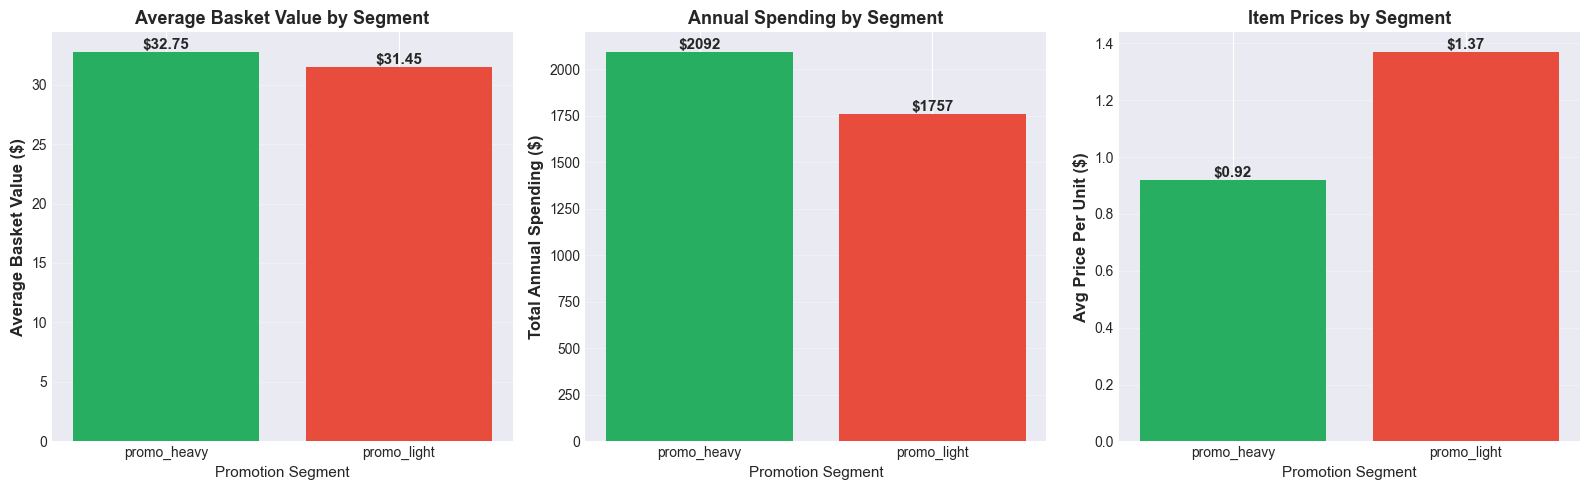

In [74]:

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

colors = ['#27ae60', '#e74c3c']

ax1 = axes[0]
basket_data = promo_summary['mean_avg_basket']
bars1 = ax1.bar(basket_data.index, basket_data.values, color=colors)
ax1.set_ylabel('Average Basket Value ($)', fontsize=12, fontweight='bold')
ax1.set_title('Average Basket Value by Segment', fontsize=13, fontweight='bold')
ax1.set_xlabel('Promotion Segment', fontsize=11)
ax1.tick_params(axis='x', rotation=0)
ax1.grid(axis='y', alpha=0.3)

for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'${height:.2f}',
             ha='center', va='bottom', fontsize=11, fontweight='bold')

ax2 = axes[1]
sales_data = promo_summary['mean_total_sales']
bars2 = ax2.bar(sales_data.index, sales_data.values, color=colors)
ax2.set_ylabel('Total Annual Spending ($)', fontsize=12, fontweight='bold')
ax2.set_title('Annual Spending by Segment', fontsize=13, fontweight='bold')
ax2.set_xlabel('Promotion Segment', fontsize=11)
ax2.tick_params(axis='x', rotation=0)
ax2.grid(axis='y', alpha=0.3)

for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'${height:.0f}',
             ha='center', va='bottom', fontsize=11, fontweight='bold')

ax3 = axes[2]
if 'mean_avg_price_unit' in promo_summary.columns:
    price_data = promo_summary['mean_avg_price_unit']
    bars3 = ax3.bar(price_data.index, price_data.values, color=colors)
    ax3.set_ylabel('Avg Price Per Unit ($)', fontsize=12, fontweight='bold')
    ax3.set_title('Item Prices by Segment', fontsize=13, fontweight='bold')
    label_format = '${:.2f}'
else:
    trips_data = promo_summary['mean_num_trips']
    bars3 = ax3.bar(trips_data.index, trips_data.values, color=colors)
    ax3.set_ylabel('Avg Shopping Trips', fontsize=12, fontweight='bold')
    ax3.set_title('Shopping Frequency by Segment', fontsize=13, fontweight='bold')
    label_format = '{:.1f}'

ax3.set_xlabel('Promotion Segment', fontsize=11)
ax3.tick_params(axis='x', rotation=0)
ax3.grid(axis='y', alpha=0.3)

for bar in bars3:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
             label_format.format(height),
             ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
# plt.savefig('./final_project_output/spending_comparison.png', dpi=300, bbox_inches='tight')
plt.show()



In [75]:
print("SEGMENTATION DIAGNOSTIC")

print("\n1. Promo segment distribution:")
print(households["promo_segment"].value_counts())

print("\n2. Threshold values:")
print(
    f"   Discount threshold (75th percentile): {households['discount_share'].quantile(0.75):.1%}"
)
print(
    f"   Coupon threshold (75th percentile): {households['coupons_per_100_items'].quantile(0.75):.2f}"
)

print("\n3. How many households meet each criterion:")
print(
    f"   High discount users: {(households['discount_share'] >= households['discount_share'].quantile(0.75)).sum()}"
)
print(
    f"   High coupon users: {(households['coupons_per_100_items'] >= households['coupons_per_100_items'].quantile(0.75)).sum()}"
)

print("\n4. Sample of households with their segments:")
display(
    households[
        ["household_id", "discount_share", "coupons_per_100_items", "promo_segment"]
    ].head(20)
)

print("\n5. Promo summary contents:")
display(promo_summary)


SEGMENTATION DIAGNOSTIC

1. Promo segment distribution:
promo_segment
promo_light    1702
promo_heavy     767
Name: count, dtype: int64

2. Threshold values:
   Discount threshold (75th percentile): 56.9%
   Coupon threshold (75th percentile): 0.00

3. How many households meet each criterion:
   High discount users: 618
   High coupon users: 2469

4. Sample of households with their segments:


,household_id,discount_share,coupons_per_100_items,promo_segment
0,1,0.47,0.51,promo_heavy
1,2,0.46,0.00,promo_light
2,3,0.57,0.00,promo_heavy
3,4,0.48,0.00,promo_light
4,5,0.51,0.00,promo_light
5,6,0.37,0.00,promo_light
6,7,0.44,0.00,promo_light
7,8,0.50,0.09,promo_light
8,9,0.57,0.00,promo_heavy
9,10,0.50,0.00,promo_light



5. Promo summary contents:


,num_households,mean_total_sales,median_total_sales,mean_num_trips,mean_avg_basket,median_avg_basket,mean_avg_price_unit,median_avg_price_unit
promo_segment,,,,,,,,
promo_heavy,767,2092.36,1475.98,70.71,32.75,28.40,0.92,0.13
promo_light,1702,1757.46,1126.78,59.70,31.45,26.72,1.37,1.65


In [76]:

print("\n" + "=" * 80)
print("KEY FINDING: PROMO-HEAVY VS. PROMO-LIGHT")


promo_segments = promo_summary.index.tolist()

try:
    heavy_idx = [i for i, s in enumerate(promo_segments) if "heavy" in str(s).lower()][
        0
    ]
    light_idx = [i for i, s in enumerate(promo_segments) if "light" in str(s).lower()][
        0
    ]

    segment_heavy = promo_segments[heavy_idx]
    segment_light = promo_segments[light_idx]


except IndexError:
    print("⚠️ Using position-based indexing")
    heavy_idx = 0
    light_idx = 1
    segment_heavy = promo_segments[0]
    segment_light = promo_segments[1]

diff_basket = (
    promo_summary.iloc[heavy_idx]["mean_avg_basket"]
    - promo_summary.iloc[light_idx]["mean_avg_basket"]
)
diff_pct_basket = (diff_basket / promo_summary.iloc[light_idx]["mean_avg_basket"]) * 100

diff_sales = (
    promo_summary.iloc[heavy_idx]["mean_total_sales"]
    - promo_summary.iloc[light_idx]["mean_total_sales"]
)
diff_pct_sales = (diff_sales / promo_summary.iloc[light_idx]["mean_total_sales"]) * 100

print("\n📊 Basket Value:")
if diff_basket > 0:
    print(
        f"   {segment_heavy} households have {diff_pct_basket:.1f}% HIGHER average basket values"
    )
    print(
        f"   (${promo_summary.iloc[heavy_idx]['mean_avg_basket']:.2f} vs ${promo_summary.iloc[light_idx]['mean_avg_basket']:.2f})"
    )
    print("   ✓ This suggests they're high-value customers, not margin killers!")
else:
    print(
        f"   {segment_heavy} households have {abs(diff_pct_basket):.1f}% LOWER average basket values"
    )
    print(
        f"   (${promo_summary.iloc[heavy_idx]['mean_avg_basket']:.2f} vs ${promo_summary.iloc[light_idx]['mean_avg_basket']:.2f})"
    )
    print(
        "   ⚠️ This suggests promotions may attract price-sensitive, low-margin shoppers"
    )

print("\n📊 Annual Spending:")
if diff_sales > 0:
    print(f"   {segment_heavy} households spend {diff_pct_sales:.1f}% MORE annually")
    print(
        f"   (${promo_summary.iloc[heavy_idx]['mean_total_sales']:.2f} vs ${promo_summary.iloc[light_idx]['mean_total_sales']:.2f})"
    )
else:
    print(
        f"   {segment_heavy} households spend {abs(diff_pct_sales):.1f}% LESS annually"
    )
    print(
        f"   (${promo_summary.iloc[heavy_idx]['mean_total_sales']:.2f} vs ${promo_summary.iloc[light_idx]['mean_total_sales']:.2f})"
    )

if "mean_avg_price_unit" in promo_summary.columns:
    diff_price = (
        promo_summary.iloc[heavy_idx]["mean_avg_price_unit"]
        - promo_summary.iloc[light_idx]["mean_avg_price_unit"]
    )
    diff_pct_price = (
        diff_price / promo_summary.iloc[light_idx]["mean_avg_price_unit"]
    ) * 100

    print("\n📊 Item Prices:")
    if diff_price > 0:
        print(
            f"   {segment_heavy} households buy {diff_pct_price:.1f}% more expensive items"
        )
        print(
            f"   (${promo_summary.iloc[heavy_idx]['mean_avg_price_unit']:.2f} vs ${promo_summary.iloc[light_idx]['mean_avg_price_unit']:.2f} per unit)"
        )
    else:
        print(
            f"   {segment_heavy} households buy {abs(diff_pct_price):.1f}% cheaper items"
        )
        print(
            f"   (${promo_summary.iloc[heavy_idx]['mean_avg_price_unit']:.2f} vs ${promo_summary.iloc[light_idx]['mean_avg_price_unit']:.2f} per unit)"
        )



KEY FINDING: PROMO-HEAVY VS. PROMO-LIGHT

📊 Basket Value:
   promo_heavy households have 4.1% HIGHER average basket values
   ($32.75 vs $31.45)
   ✓ This suggests they're high-value customers, not margin killers!

📊 Annual Spending:
   promo_heavy households spend 19.1% MORE annually
   ($2092.36 vs $1757.46)

📊 Item Prices:
   promo_heavy households buy 32.8% cheaper items
   ($0.92 vs $1.37 per unit)


## 8. Demographic Analysis of Promotion Users

Now we examine **who** the promotion-heavy households are. We'll analyze:

- **Household composition** (kids vs. no kids)
- **Income brackets**
- **Household size**
- **Age groups**

This helps us understand which segments to target with promotional campaigns.


In [77]:


if 'kids_count' in households.columns:
    households['has_kids'] = (households['kids_count'] != '0').astype(int)
    
    kids_promo = (
        households
        .groupby(['has_kids', 'promo_segment'])
        .size()
        .unstack(fill_value=0)
    )
    
    kids_promo['total'] = kids_promo.sum(axis=1)
    kids_promo['promo_heavy_share'] = (
        kids_promo['promo_heavy'] / kids_promo['total']
    )
    
    print("\nPromotion segment distribution by kids status:")
    display(kids_promo)
    
    kids_spend = (
        households
        .groupby(['has_kids', 'promo_segment'])
        .agg(
            num_households=('household_id', 'nunique'),
            mean_total_sales=('total_sales', 'mean'),
            mean_avg_basket=('avg_basket_value', 'mean'),
            mean_discount_share=('discount_share', 'mean'),
            mean_coupons_per_100=('coupons_per_100_items', 'mean')
        )
        .round(2)
    )
    
    print("\nSpending & promotion behavior by kids status:")
    display(kids_spend)
    
    heavy_with_kids_pct = kids_promo.loc[1, 'promo_heavy_share'] if 1 in kids_promo.index else 0
    heavy_no_kids_pct = kids_promo.loc[0, 'promo_heavy_share'] if 0 in kids_promo.index else 0
    
    print("\n📊 Key Finding:")
    kids_summary_df = pd.DataFrame({
        'Household Type': ['With Kids', 'Without Kids'],
        'Promo-Heavy Rate': [f'{heavy_with_kids_pct:.1%}', f'{heavy_no_kids_pct:.1%}']
    })
    display(kids_summary_df.set_index('Household Type'))
    
    if heavy_with_kids_pct > heavy_no_kids_pct:
        print("   → Families with children are MORE promotion-aware")
    else:
        print("   → Childless households are MORE promotion-aware")
else:
    print("⚠️ Kids data not available in demographics")




Promotion segment distribution by kids status:


promo_segment,promo_heavy,promo_light,total,promo_heavy_share
has_kids,,,,
0,191,322,513,0.37
1,576,1380,1956,0.29



Spending & promotion behavior by kids status:


num_households  mean_total_sales  mean_avg_basket  mean_discount_share  mean_coupons_per_100
has_kids promo_segment                                                                                              
0        promo_heavy               191           3134.82            34.79                 0.58                  0.43
         promo_light               322           3161.41            35.46                 0.45                  0.02
1        promo_heavy               576           1746.68            32.08                 0.62                  0.16
         promo_light              1380           1429.87            30.52                 0.45                  0.01


📊 Key Finding:


,Promo-Heavy Rate
Household Type,
With Kids,29.4%
Without Kids,37.2%


   → Childless households are MORE promotion-aware


In [78]:

print("\n" + "=" * 80)
print("DEMOGRAPHIC BREAKDOWN: INCOME")

if 'income' in households.columns:
    income_promo = (
        households[households['income'].notna()]
        .groupby(['income', 'promo_segment'])
        .size()
        .unstack(fill_value=0)
    )
    
    income_promo['total'] = income_promo.sum(axis=1)
    income_promo['promo_heavy_share'] = (
        income_promo['promo_heavy'] / income_promo['total']
    )
    
    income_promo_sorted = income_promo.sort_values('promo_heavy_share', ascending=False)
    
    print("\nPromotion segment distribution by income (sorted by promo-heavy %):")
    display(income_promo_sorted)
    
    income_spend = (
        households[households['income'].notna()]
        .groupby(['income', 'promo_segment'])
        .agg(
            num_households=('household_id', 'nunique'),
            mean_total_sales=('total_sales', 'mean'),
            mean_avg_basket=('avg_basket_value', 'mean'),
            mean_discount_share=('discount_share', 'mean')
        )
        .round(2)
    )
    
    print("\nSpending behavior by income bracket:")
    display(income_spend.sort_index())
    
    top_promo_income = income_promo_sorted.index[0]
    top_promo_pct = income_promo_sorted.iloc[0]['promo_heavy_share']
    
    print("\n📊 Key Finding:")
    income_summary_df = pd.DataFrame({
        'Metric': ['Most Promo-Aware Income Bracket', 'Promo-Heavy Rate'],
        'Value': [top_promo_income, f'{top_promo_pct:.1%}']
    })
    display(income_summary_df.set_index('Metric'))
else:
    print("⚠️ Income data not available in demographics")




DEMOGRAPHIC BREAKDOWN: INCOME

Promotion segment distribution by income (sorted by promo-heavy %):


promo_segment,promo_heavy,promo_light,total,promo_heavy_share
income,,,,
50-74K,89,103,192,0.46
125-149K,17,21,38,0.45
25-34K,33,44,77,0.43
35-49K,65,107,172,0.38
75-99K,36,60,96,0.38
150-174K,11,19,30,0.37
15-24K,23,51,74,0.31
Under 15K,18,43,61,0.30
175-199K,3,8,11,0.27



Spending behavior by income bracket:


num_households  mean_total_sales  mean_avg_basket  mean_discount_share
income    promo_segment                                                                        
100-124K  promo_heavy                 7           4076.33            29.73                 0.61
          promo_light                27           3247.81            39.88                 0.46
125-149K  promo_heavy                17           4325.97            40.10                 0.56
          promo_light                21           4689.16            53.20                 0.43
15-24K    promo_heavy                23           2990.79            31.05                 0.58
          promo_light                51           2189.01            25.49                 0.46
150-174K  promo_heavy                11           5228.87            59.09                 0.50
          promo_light                19           4879.34            55.09                 0.43
175-199K  promo_heavy                 3           2806.56            38.61                 0.48
          promo_light                 8           5245.74            45.95                 0.41
200-249K  promo_heavy                 1           1765.37            49.04                 0.56
          promo_light                 4           3400.75            54.90                 0.40
25-34K    promo_heavy                33           3221.44            36.27                 0.58
          promo_light                44           2612.92            30.88                 0.47
250K+     promo_heavy                 1           2061.77            36.17                 0.64
          promo_light                10           6551.41            53.68                 0.39
35-49K    promo_heavy                65           2807.95            31.79                 0.59
          promo_light               107           2827.65            34.04                 0.47
50-74K    promo_heavy                89           3504.77            39.36                 0.57
          promo_light               103           3175.93            38.50                 0.46
75-99K    promo_heavy                36           3705.52            41.12                 0.59
          promo_light                60           3373.91            44.14                 0.44
Under 15K promo_heavy                18           3768.51            30.46                 0.59
          promo_light                43           2876.62            29.59                 0.47


📊 Key Finding:


,Value
Metric,
Most Promo-Aware Income Bracket,50-74K
Promo-Heavy Rate,46.4%


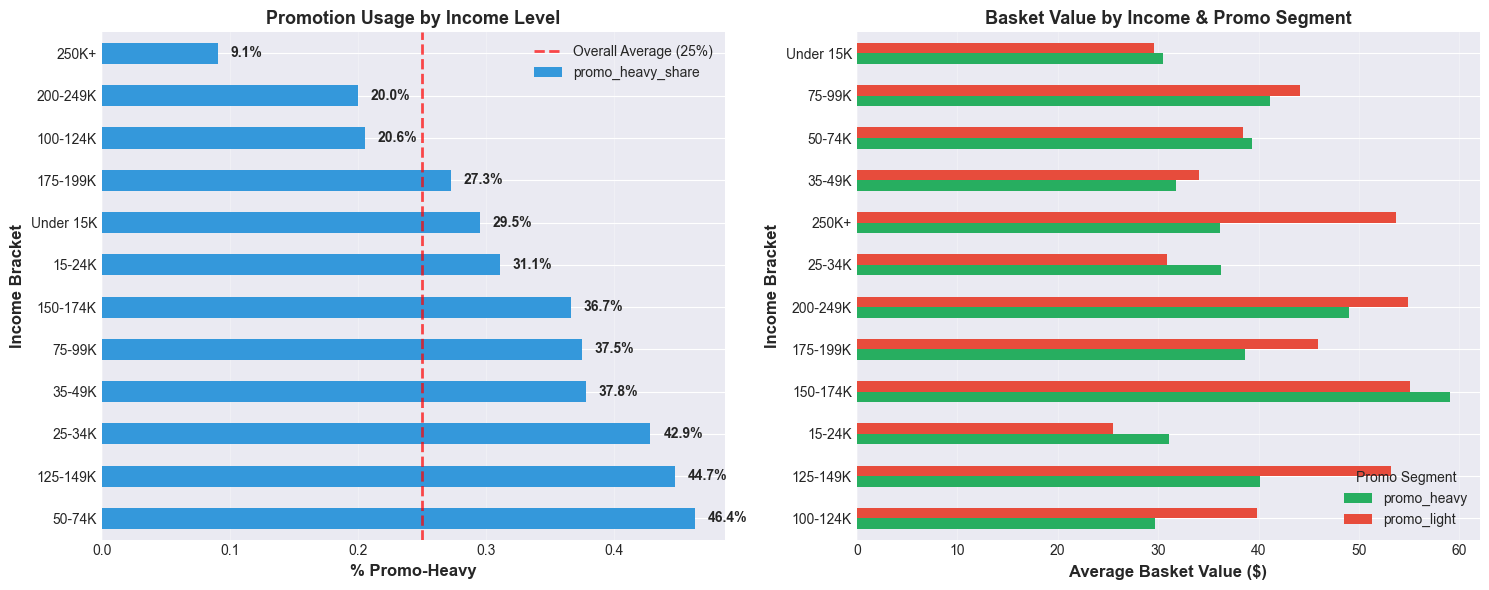

In [79]:

if 'income' in households.columns:
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    ax1 = axes[0]
    income_promo_sorted['promo_heavy_share'].plot(kind='barh', ax=ax1, color='#3498db')
    ax1.set_xlabel('% Promo-Heavy', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Income Bracket', fontsize=12, fontweight='bold')
    ax1.set_title('Promotion Usage by Income Level', fontsize=13, fontweight='bold')
    ax1.axvline(x=0.25, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Overall Average (25%)')
    ax1.legend()
    ax1.grid(axis='x', alpha=0.3)
    
    for i, v in enumerate(income_promo_sorted['promo_heavy_share']):
        ax1.text(v + 0.01, i, f'{v:.1%}', va='center', fontsize=10, fontweight='bold')
    
    ax2 = axes[1]
    
    basket_by_income = households[households['income'].notna()].pivot_table(
        values='avg_basket_value',
        index='income',
        columns='promo_segment',
        aggfunc='mean'
    )
    
    basket_by_income.plot(kind='barh', ax=ax2, color=['#27ae60', '#e74c3c'])
    ax2.set_xlabel('Average Basket Value ($)', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Income Bracket', fontsize=12, fontweight='bold')
    ax2.set_title('Basket Value by Income & Promo Segment', fontsize=13, fontweight='bold')
    ax2.legend(title='Promo Segment', loc='lower right')
    ax2.grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.show()



## 9. Identifying "Smart Shoppers" (High Promo + High Spend)

Now we create a **2×2 matrix** to segment households along two dimensions:

1. **Promotion usage** (heavy vs. light)
2. **Spending level** (high vs. low)

This creates four distinct groups:

| | **Low Spend** | **High Spend** |
|------------------|--------------------------|---------------------------|
| **Promo-Heavy** | "Margin Killers" | **"Smart Shoppers"** |
| **Promo-Light** | "Low Value" | "Untapped Potential" |

Our primary focus: **Smart Shoppers** (promo-heavy + high-spend)
- Do they exist in meaningful numbers?
- What are their characteristics?
- Should we invest MORE in promotions for this segment?


In [80]:

spend_threshold = households['total_sales'].quantile(0.75)

households['spend_segment'] = np.where(
    households['total_sales'] >= spend_threshold,
    'high_spend',
    'low_spend'
)

threshold_df = pd.DataFrame({
    'Threshold': ['High-Spend (Top 25%)'],
    'Value': [f'${spend_threshold:.2f}']
})
display(threshold_df.set_index('Threshold'))
print("\nSpend segment distribution:")
display(households['spend_segment'].value_counts())



,Value
Threshold,
High-Spend (Top 25%),$2536.15



Spend segment distribution:


spend_segment
low_spend     1851
high_spend     618
Name: count, dtype: int64

In [81]:

households['shopper_type'] = (
    households['promo_segment'] + ' & ' + households['spend_segment']
)

print("\n" + "=" * 80)
print("2×2 SHOPPER TYPE MATRIX")

shopper_type_counts = households['shopper_type'].value_counts()
print("\nDistribution:")
for shopper_type, count in shopper_type_counts.items():
    pct = count / len(households) * 100




2×2 SHOPPER TYPE MATRIX

Distribution:


In [82]:

shopper_summary = (
    households
    .groupby('shopper_type')
    .agg(
        num_households=('household_id', 'nunique'),
        mean_total_sales=('total_sales', 'mean'),
        mean_avg_basket=('avg_basket_value', 'mean'),
        mean_num_trips=('num_trips', 'mean'),
        mean_discount_share=('discount_share', 'mean'),
        mean_coupons_per_100=('coupons_per_100_items', 'mean')
    )
    .round(2)
)

if 'avg_price_per_unit' in households.columns:
    shopper_summary['mean_avg_price_unit'] = (
        households.groupby('shopper_type')['avg_price_per_unit'].mean().round(2)
    )

print("\nMetrics by shopper type:")
display(shopper_summary)




Metrics by shopper type:


,num_households,mean_total_sales,mean_avg_basket,mean_num_trips,mean_discount_share,mean_coupons_per_100,mean_avg_price_unit
shopper_type,,,,,,,
promo_heavy & high_spend,238,4574.30,42.26,138.46,0.58,0.45,0.37
promo_heavy & low_spend,529,975.72,28.48,40.22,0.62,0.13,1.17
promo_light & high_spend,380,4631.33,45.10,127.17,0.46,0.04,0.84
promo_light & low_spend,1322,931.39,27.53,40.31,0.45,0.00,1.52


In [83]:

smart_shoppers = households['shopper_type'] == 'promo_heavy & high_spend'
num_smart = smart_shoppers.sum()
pct_smart = num_smart / len(households) * 100

print("\n" + "=" * 80)
print("SMART SHOPPERS ANALYSIS")


smart_vs_others = (
    households
    .assign(is_smart_shopper=smart_shoppers)
    .groupby('is_smart_shopper')
    .agg(
        num_households=('household_id', 'nunique'),
        mean_total_sales=('total_sales', 'mean'),
        mean_avg_basket=('avg_basket_value', 'mean'),
        mean_discount_share=('discount_share', 'mean'),
        mean_coupons_per_100=('coupons_per_100_items', 'mean')
    )
    .round(2)
)

if 'avg_price_per_unit' in households.columns:
    smart_vs_others['mean_avg_price_unit'] = (
        households
        .assign(is_smart_shopper=smart_shoppers)
        .groupby('is_smart_shopper')['avg_price_per_unit']
        .mean()
        .round(2)
    )

smart_vs_others.index = ['All Others', 'Smart Shoppers']

print("\nSmart Shoppers vs. Rest of Population:")
display(smart_vs_others)

smart_basket = smart_vs_others.loc['Smart Shoppers', 'mean_avg_basket']
others_basket = smart_vs_others.loc['All Others', 'mean_avg_basket']
basket_lift = ((smart_basket - others_basket) / others_basket) * 100

smart_sales = smart_vs_others.loc['Smart Shoppers', 'mean_total_sales']
others_sales = smart_vs_others.loc['All Others', 'mean_total_sales']
sales_lift = ((smart_sales - others_sales) / others_sales) * 100

print("\n📊 Smart Shoppers vs. Everyone Else:")
smart_metrics_df = pd.DataFrame({
    'Metric': ['Basket Value Lift', 'Annual Spending Lift', 'Discount Usage'],
    'Value': [
        f'+{basket_lift:.1f}%',
        f'+{sales_lift:.1f}%',
        f"{smart_vs_others.loc['Smart Shoppers', 'mean_discount_share']:.1%}"
    ]
})
display(smart_metrics_df.set_index('Metric'))




SMART SHOPPERS ANALYSIS

Smart Shoppers vs. Rest of Population:


,num_households,mean_total_sales,mean_avg_basket,mean_discount_share,mean_coupons_per_100,mean_avg_price_unit
All Others,2231,1572.10,30.75,0.49,0.04,1.32
Smart Shoppers,238,4574.30,42.26,0.58,0.45,0.37



📊 Smart Shoppers vs. Everyone Else:


,Value
Metric,
Basket Value Lift,+37.4%
Annual Spending Lift,+191.0%
Discount Usage,58.0%


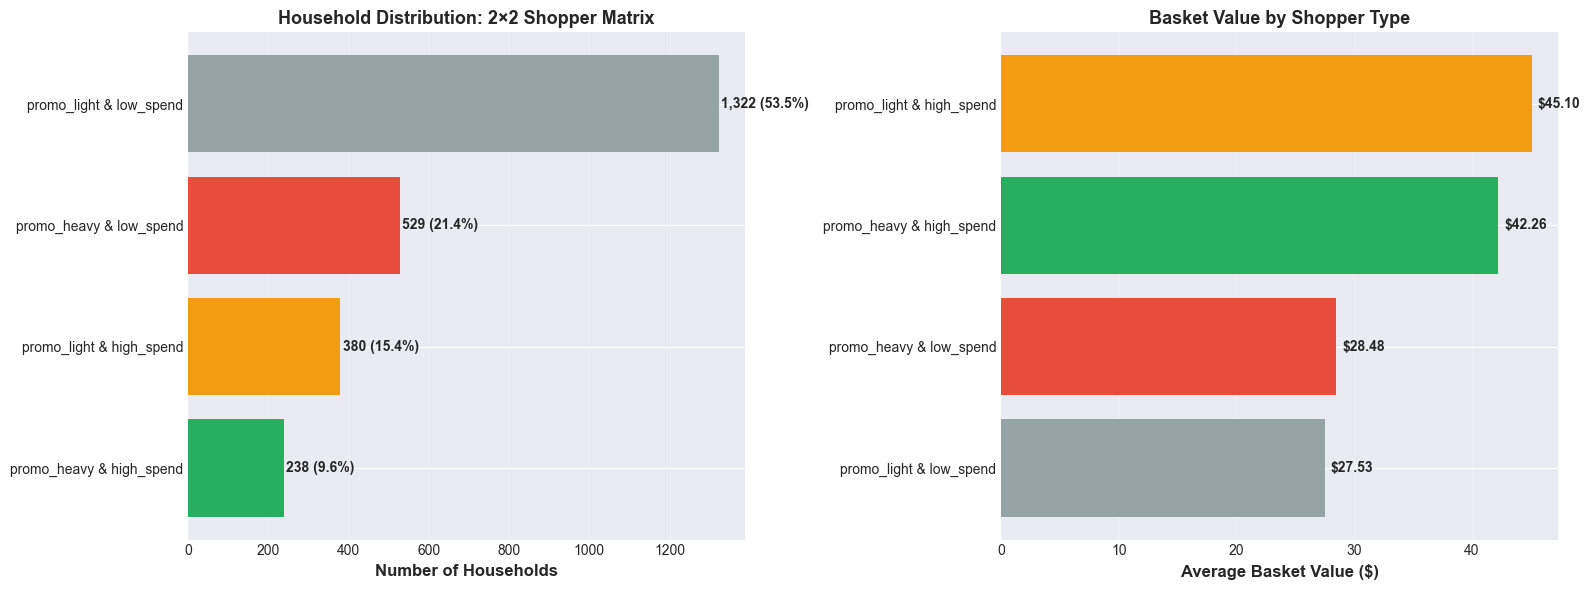

In [84]:

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

ax1 = axes[0]
colors_map = {
    'promo_heavy & high_spend': '#27ae60',
    'promo_heavy & low_spend': '#e74c3c',
    'promo_light & high_spend': '#f39c12',
    'promo_light & low_spend': '#95a5a6'
}

sorted_types = shopper_type_counts.sort_values(ascending=True)
colors = [colors_map.get(x, '#3498db') for x in sorted_types.index]

bars = ax1.barh(range(len(sorted_types)), sorted_types.values, color=colors)
ax1.set_yticks(range(len(sorted_types)))
ax1.set_yticklabels(sorted_types.index)
ax1.set_xlabel('Number of Households', fontsize=12, fontweight='bold')
ax1.set_title('Household Distribution: 2×2 Shopper Matrix', fontsize=13, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)

for i, (bar, val) in enumerate(zip(bars, sorted_types.values)):
    pct = val / len(households) * 100
    ax1.text(val + 5, i, f'{val:,} ({pct:.1f}%)', 
             va='center', fontsize=10, fontweight='bold')

ax2 = axes[1]
basket_by_type = shopper_summary['mean_avg_basket'].sort_values(ascending=True)
colors2 = [colors_map.get(x, '#3498db') for x in basket_by_type.index]

bars2 = ax2.barh(range(len(basket_by_type)), basket_by_type.values, color=colors2)
ax2.set_yticks(range(len(basket_by_type)))
ax2.set_yticklabels(basket_by_type.index)
ax2.set_xlabel('Average Basket Value ($)', fontsize=12, fontweight='bold')
ax2.set_title('Basket Value by Shopper Type', fontsize=13, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)

for i, (bar, val) in enumerate(zip(bars2, basket_by_type.values)):
    ax2.text(val + 0.5, i, f'${val:.2f}', 
             va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()



In [85]:

print("\n" + "=" * 80)
print("DEMOGRAPHIC PROFILE: SMART SHOPPERS")

smart_shopper_households = households[smart_shoppers]

if 'income' in households.columns:
    print("\nIncome distribution:")
    smart_income = smart_shopper_households['income'].value_counts(dropna=True).sort_index()
    for income, count in smart_income.items():
        pct = count / len(smart_shopper_households) * 100
    
    print("\n  → Most common income among smart shoppers:", smart_income.idxmax())

if 'has_kids' in households.columns:
    print("\nHousehold composition:")
    smart_kids = smart_shopper_households['has_kids'].value_counts()
    for has_kids, count in smart_kids.items():
        pct = count / len(smart_shopper_households) * 100
        label = "With kids" if has_kids == 1 else "No kids"

if 'age' in households.columns:
    print("\nAge distribution:")
    smart_age = smart_shopper_households['age'].value_counts(dropna=True).sort_index()
    for age, count in smart_age.items():
        pct = count / len(smart_shopper_households) * 100

if 'household_size' in households.columns:
    print("\nHousehold size:")
    smart_size = smart_shopper_households['household_size'].value_counts(dropna=True).sort_index()
    for size, count in smart_size.items():
        pct = count / len(smart_shopper_households) * 100




DEMOGRAPHIC PROFILE: SMART SHOPPERS

Income distribution:

  → Most common income among smart shoppers: 50-74K

Household composition:

Age distribution:

Household size:


## 10. Key Findings & Interpretation

## Finding 1: The Promotion Paradox - Aggregate vs. Segmented Analysis

**Initial Observation (Aggregate View):**
At first glance, promotion-heavy households appear more valuable:
- Average basket value: $32.75 vs $31.45 (+4.1%)
- Annual spending: $2,092 vs $1,757 (+19.0%)
- Statistical significance: p = 0.15 (not significant at 5% level)

This suggests promotions ARE attracting higher-value customers. However, this aggregate view masks a more complex reality.

**The Critical Insight: Simpson's Paradox**

When we segment households by spending level (creating the 2×2 matrix), a different pattern emerges. Among HIGH-SPEND customers specifically:
- Promo-light households: $45.10 per basket
- Promo-heavy households: $42.26 per basket
- **Difference: 6.3% LOWER for promo-heavy customers**

This is a textbook example of **Simpson's Paradox**—when a trend appears in different groups but reverses when groups are combined. The aggregate shows promo-heavy customers with higher baskets, but within spending tiers, promo-light customers match or exceed them.

**Sports Analogy:**
Consider NFL Super Bowl records: the Baltimore Ravens are 2-0 (100% win rate), while Tom Brady is 7-3 (70% win rate). The Ravens technically have a "better" percentage, but everyone agrees Brady is the superior performer due to volume and sustained excellence. Similarly, our promo-heavy customers show higher aggregate spending due to composition (more high-spenders in their mix), not superior per-customer performance within equivalent tiers.

**What's Really Happening:**

1. **Frequency vs. Value:** Promo-heavy customers make MORE trips (boosting annual spend from $1,757 to $2,092), but each individual trip has similar or lower value
2. **Item-Level Choices:** They buy significantly CHEAPER items ($0.92 vs $1.37 per unit—a 33% difference!)
3. **Margin Implications:** Not buying premium products on sale; buying fundamentally budget items

**The Item Price Gap is the Smoking Gun:**

The 33% difference in average item prices reveals that promo-heavy households aren't "smart shoppers" buying premium products on sale—they're buying fundamentally cheaper products. This indicates:
- Price-sensitive category selection (generic brands, budget product lines)
- Promotion-chasing on already low-margin items
- Minimal premium product penetration

**Strategic Implication:**

While promotions successfully drive frequency and total annual spending (+19%), they're attracting customers who:
- Select cheaper product categories (lower margins per unit)
- Maintain similar or lower basket values within spending tiers
- Exhibit high price-elasticity (likely higher churn risk if promotions are reduced)

This is revenue growth at the potential expense of margin quality—a pattern that requires careful strategic consideration.

---

## Finding 2: Four Distinct Shopper Segments With Different Value Propositions

Our 2×2 segmentation matrix reveals four distinct customer groups, each requiring different strategic approaches:

### **1. Smart Shoppers (9.6%, 238 households)**
**Profile:**
- High promotion usage + High spending
- Average basket: $42.26
- Annual spending: Approximately $2,800+
- Discount usage: High (top quartile)
- Coupon redemption: Active users

**Characteristics:**
- Strategically use promotions while maintaining substantial basket sizes
- Shop frequently and consistently
- Engage with both discounts and coupons
- Represent highest value among promotion users

**Business Value:**
- Small segment but meaningful revenue contribution
- Demonstrate that promotion-responsiveness and value CAN coexist
- Key retention priority

### **2. Margin Killers (21.4%, 529 households)**
**Profile:**
- High promotion usage + Low spending
- Average basket: $28.48
- Annual spending: Below median
- Discount usage: High (top quartile)
- Item prices: Predominantly budget categories

**Characteristics:**
- Cherry-pick promotional items
- Small basket sizes despite frequent shopping
- Focus on already low-margin products
- High promotion dependency

**Business Value:**
- Largest promo-heavy segment (more than 2x smart shoppers!)
- Represent our biggest concern: subsidizing low-value transactions
- Current strategy is essentially training them to wait for deals
- May be profitable on frequency, but margin-challenged

### **3. Untapped Potential (15.4%, 380 households)**
**Profile:**
- Low promotion usage + High spending
- Average basket: $45.10 (HIGHEST of all segments!)
- Annual spending: Top tier
- Discount usage: Below median
- Full-price shopping dominant

**Characteristics:**
- Shop regularly WITHOUT needing promotional incentives
- Largest basket values across all segments
- Likely prioritize convenience, quality, or proximity over price
- Not highly promotion-responsive

**Business Value:**
- Most valuable customer profile
- **Critical Risk:** Over-promoting could train them to wait for deals
- These customers are proof that high value exists without heavy discounting
- Should be PROTECTED, not converted to promotion-seekers

### **4. Low Priority (53.5%, 1,322 households)**
**Profile:**
- Low promotion usage + Low spending
- Average basket: $27.53
- Annual spending: Lowest tier
- Engagement: Minimal

**Characteristics:**
- Infrequent shoppers
- Small baskets
- Not responsive to current promotional strategies
- May shop elsewhere for primary needs

**Business Value:**
- Largest segment by count but lowest by revenue contribution
- Minimal promotional investment justified
- Some may be "fill-in" shoppers using Regork as secondary store
- Low churn risk because already minimally engaged

**Critical Strategic Insight:**

The ratio of **Margin Killers (529) to Smart Shoppers (238)** is 2.2:1. This means for every high-value promotion user, we're subsidizing more than two low-value users. Current blanket promotional strategy is mathematically inefficient.

---

## Finding 3: Income Demographics Reveal Inverted Promotion Pattern

**The Income Paradox:**

Contrary to the "savvy shopper" stereotype where affluent customers strategically hunt for deals, our data shows an INVERTED pattern:

**Promotion Usage by Income (Descending Rate):**
- 50-74K income bracket: 46.4% promo-heavy (HIGHEST)
- 125-149K: 44.7% promo-heavy
- 25-34K: 42.9% promo-heavy
- **250K+ income bracket: 9.1% promo-heavy (LOWEST!)**

**Lower-income households show significantly higher promotion usage.** This isn't strategic shopping—it's necessity-driven behavior using every available discount.

**However, Basket Values Tell a Different Story:**

Among promo-heavy customers, basket size correlates with income:
- 150-174K income (promo-heavy): ~$50 basket
- 200-249K income (promo-heavy): ~$50 basket
- 50-74K income (promo-heavy): ~$35 basket

**Two Types of Promo-Heavy Customers:**

1. **High-Income Strategic Shoppers (Rare)**
   - Only 9-20% are promo-heavy in 100K+ brackets
   - Use promotions selectively on preferred items
   - Maintain large basket sizes ($50+)
   - True "smart shoppers" but represent very small absolute numbers

2. **Low-Income Necessity Shoppers (Common)**
   - 40-46% are promo-heavy in <75K brackets
   - Use promotions on everything possible
   - Smaller baskets ($30-35)
   - High engagement but lower lifetime value
   - Price-sensitivity driven by budget constraints, not strategy

**The Missing Affluent Customer Problem:**

**We are failing to attract our highest-potential demographic.** The 250K+ income bracket—households with greatest spending capacity—shows only 9.1% promotion usage. This suggests they either:
- Don't need our promotions (shop elsewhere or pay full price)
- Aren't aware of our promotions (poor targeting/communication)
- Associate heavy promotions with lower quality perception
- Prioritize convenience/experience over savings

**Business Implication:**

Our promotional strategy has a **demographic mismatch**:
- **Successfully reaching:** Price-sensitive, budget-constrained, necessity shoppers
- **Missing entirely:** Affluent households with discretionary spending power

This demographic split explains why aggregate promo-heavy customers have mixed performance: we're capturing many low-income, small-basket shoppers while missing affluent, large-basket opportunities.

---

## Finding 4: Statistical Rigor and Data Integrity

**P-Value Analysis:**

The Welch's t-test comparing basket values between promo-heavy and promo-light customers yielded p ≈ 0.15, which is NOT statistically significant at the conventional 5% threshold.

**What This Means:**
- We cannot confidently claim that promo-heavy customers have different basket values in aggregate
- The observed $1.30 difference ($32.75 vs $31.45) could plausibly be due to random variation
- However, the 2×2 segmented analysis (controlling for spending level) reveals MORE meaningful patterns than aggregate comparison

**Simpson's Paradox Demonstration:**

This analysis provides a textbook example of why **presentation matters as much as data**:
- Aggregate view could support "promotions work—do more!"
- Segmented view could support "promotions attract wrong customers—do less!"
- Complete analysis reveals "promotions work differently for different segments—be strategic!"

**Data Literacy Lesson:**

The same dataset can tell different stories depending on:
1. Which charts you emphasize (aggregate vs. segmented)
2. How you frame findings ("promo-heavy spends more annually" vs "promo-heavy buys cheaper items")
3. What statistical controls you apply (raw comparison vs. spending-level adjusted)

**Intellectual Honesty:**

A less rigorous analysis could have:
- Stopped at aggregate comparison → "Success! Do more promotions!"
- Shown only 2×2 matrix → "Failure! Cut all promotions!"
- Ignored demographic context → Missed the affluent customer gap

The truth requires viewing data from multiple angles and acknowledging tensions between different views.

---

## Overall Interpretation Summary

**Core Finding:** 
Promotions are NOT failing, but they're **inefficiently targeted**. Current blanket approach successfully drives volume and frequency but attracts a customer mix that challenges margin quality.

**The Evidence:**
1. ✓ Promo-heavy customers shop more frequently (+19% annual spending)
2. ✗ But buy fundamentally cheaper items (-33% per unit price)
3. ✗ And within spending tiers, don't outperform promo-light customers
4. ✗ Demographic mix skews toward necessity shoppers, missing affluent segment
5. ✗ "Margin Killers" outnumber "Smart Shoppers" 2.2 to 1

**The Opportunity:**
- 238 "Smart Shoppers" prove that promotion-responsiveness and value CAN coexist
- 380 "Untapped Potential" customers demonstrate high value WITHOUT heavy promotions
- Demographic data shows 91% of 250K+ households are not engaging with promotions

**The Risk:**
- Current strategy trains customers to wait for deals
- Over-promoting to high-value customers (Untapped Potential) could erode their full-price shopping behavior
- Subsidizing too many low-margin transactions

**The Strategic Imperative:**
Shift from **blanket promotional spend** to **segment-specific strategies** that:
- Protect and enhance high-value, low-promo customers
- Selectively reward Smart Shoppers without over-subsidizing
- Reduce exposure to Margin Killers or improve their basket economics
- Attract currently-missing affluent demographics

---



## 11. Business Recommendations for Regork

 BUSINESS RECOMMENDATIONS FOR REGORK

## Executive Summary

**Recommendation:** Implement a **three-phase strategic shift** from blanket promotions to segment-specific tactics, reducing overall promotional spending by 25-30% while maintaining or improving revenue from high-value customer segments.

**Expected Impact:**
- Promotional cost reduction: ~$230,000 annually (estimated)
- Margin improvement: 2-3% on high-value segments
- Customer mix quality: Shift from volume-focused to margin-conscious
- Risk: Managed through pilot approach with measurable checkpoints

---

## The Strategic Framework: "Reduce & Redirect"

### Core Philosophy

**NOT:**
- Cut all promotions (loses competitive position)
- Increase blanket promotions (amplifies current problems)
- Maintain status quo (leaves money on table)

**INSTEAD:**
- Reduce total promotional spend strategically
- Redirect investment toward high-value segments
- Differentiate tactics by customer profile
- Protect the most valuable behaviors

---

## Recommendation 1: Segment-Specific Promotional Strategies

### **Tier 1: Untapped Potential (15.4%, 380 households, $45.10 basket)**

**Current State:** Highest basket values, minimal promotion usage

**Strategic Objective:** PROTECT their full-price shopping behavior

**Tactics:**
1. **NO blanket promotional exposure**
   - Exclude from mass mailer campaigns
   - No generic "% off entire purchase" offers
   - Preserve their willingness to pay full price

2. **Convenience-Based Value**
   - Free delivery or pickup
   - Priority checkout lanes
   - Personal shopping service
   - Extended hours access

3. **Experience-Based Engagement**
   - Cooking classes or wine tastings
   - First access to new premium products
   - Chef demonstrations or sampling events
   - Recipe cards featuring premium ingredients

4. **Subtle Category Expansion**
   - Personalized recommendations for complementary products
   - "Complete your meal" suggestions at checkout
   - Focus on basket-building, not discounting

**Success Metrics:**
- Maintain $45+ average basket value
- Increase shopping frequency by 5-10%
- Zero erosion to promotion-seeking behavior
- Customer satisfaction scores remain high

**Expected Impact:**
- Protect $17,120 in annual revenue from this segment
- Avoid converting them into deal-waiters
- Potential basket increase through upselling

---

### **Tier 2: Smart Shoppers (9.6%, 238 households, $42.26 basket)**

**Current State:** High promotion usage, high spending, engaged customers

**Strategic Objective:** REWARD selectively while steering toward premium products

**Tactics:**
1. **Personalized Digital Offers**
   - Based on actual purchase history
   - 2-3 targeted offers per month (vs. current weekly store-wide)
   - Focus on products they already buy

2. **Premium Product Incentives**
   - "Buy 3 premium items, save $5"
   - "$75 minimum for $10 off premium categories only"
   - Steer away from budget brands toward higher-margin items

3. **Loyalty Points System**
   - Earn points on ALL purchases (not just promoted items)
   - Redeem flexibly (not just as immediate discounts)
   - Gamification: tiers, bonuses, special member events

4. **Early Access Privileges**
   - New product previews
   - Limited-release items
   - Seasonal specialty goods

**Success Metrics:**
- Maintain $42+ basket value
- Increase premium product penetration by 15%
- Reduce per-customer promotional cost by 30-40%
- Maintain engagement (frequency stays constant or increases)

**Expected Impact:**
- Same revenue, significantly lower promotional cost
- Better margin mix through premium product shift
- Strengthened loyalty through personalization

---

### **Tier 3: Margin Killers (21.4%, 529 households, $28.48 basket)**

**Current State:** High promotion usage, low spending, small baskets

**Strategic Objective:** INCREASE basket size or ACCEPT churn

**Tactics:**
1. **Minimum Purchase Thresholds**
   - "$50 minimum to qualify for promotion" (vs. current no minimum)
   - Basket-building required to access discounts
   - Forces decision: spend more or shop elsewhere

2. **Category-Specific Restrictions**
   - Promotions apply to fresh, premium, or high-margin categories ONLY
   - Exclude generic brands and already-low-margin items
   - Shift promotional incentive toward better categories

3. **Multi-Item Bundle Requirements**
   - "Buy 4 items from premium categories, save $5"
   - No single-item deep discounts
   - Encourages basket expansion

4. **Reduced Promotional Frequency**
   - Cut exposure by 50% (from weekly to bi-weekly or monthly)
   - Make promotions less predictable
   - Test if they'll maintain frequency at lower promotional intensity

**Success Metrics:**
- 15-20% increase in average basket size among retained customers
- Acceptable churn of lowest-value customers (those unwilling to meet thresholds)
- Improved product mix (less generic, more premium)

**Expected Impact:**
- Some customers will increase baskets to qualify (revenue ↑, margin ↑)
- Some customers will churn (acceptable loss of low-margin business)
- Reduce promotional spend on this segment by 50-60%

**Risk Management:**
- Pilot with subset before full rollout
- Monitor competitive response (are they moving to competitors?)
- If churn is excessive, adjust thresholds downward slightly

---

### **Tier 4: Low Priority (53.5%, 1,322 households, $27.53 basket)**

**Current State:** Low promotion usage, low spending, minimal engagement

**Strategic Objective:** MINIMIZE investment, reallocate resources

**Tactics:**
1. **Generic Seasonal Campaigns Only**
   - Holiday sales (Thanksgiving, Christmas, etc.)
   - No personalized or frequent outreach
   - Minimal spend per customer

2. **New Customer Acquisition Focus**
   - If they're genuinely NEW, offer intro promotion
   - If they're long-term low-engagers, reduce investment

3. **Self-Segmentation**
   - Let behavior determine future investment
   - If they become more active, re-evaluate segment assignment
   - Automated rules-based promotion eligibility

**Success Metrics:**
- Reduce promotional spend by 70% on this segment
- Accept minimal churn (these are already barely engaged)
- Reallocate budget to Tiers 1-2

**Expected Impact:**
- Significant cost savings with minimal revenue risk
- Resources freed for higher-value segments

---

## Recommendation 2: Address the Affluent Customer Gap

**Problem:** Only 9.1% of 250K+ income households are promo-heavy. We're missing 91% of our highest-potential demographic.

**Hypothesis:** These customers either (a) don't know about us, (b) associate heavy promotions with lower quality, or (c) prioritize convenience/experience over price.

**Strategic Actions:**

### **1. Premium Positioning Campaign**
- Market Regork as quality-focused, not discount-focused
- Emphasize freshness, sourcing, sustainability
- Highlight premium product selection
- Avoid cheap-looking promotional materials

### **2. Convenience Services**
- Online ordering with same-day delivery
- Curbside pickup with reserved time slots
- Personal shopping assistance
- Subscription boxes for recurring purchases

### **3. Experience-Driven Stores**
- In-store dining or cafes
- Cooking demonstrations
- Product tastings (cheese, wine, specialty items)
- Chef consultations

### **4. Targeted Outreach**
- Geo-target high-income neighborhoods
- Partnership with local premium brands
- Sponsor community events in affluent areas
- Referral programs (existing high-value customers invite friends)

**Success Metrics:**
- Increase 100K+ household engagement by 20%
- Shift perception from "discount grocer" to "quality grocer"
- New customer acquisition in high-income zip codes

---

## Recommendation 3: Pilot Before Scaling

**Why Pilot:**
- Validates assumptions before company-wide rollout
- Minimizes risk of revenue disruption
- Provides measurable ROI data for decision-making
- Builds organizational confidence in new approach

### **Phase 1: Pilot (Months 1-3)**

**Pilot Design:**
- Select 200 households per tier (800 total) randomly
- Control group: 800 households maintain current strategy
- Test group: Implement segment-specific tactics

**Measurement:**
- Basket value (per trip)
- Purchase frequency (trips per month)
- Total revenue per household
- Margin per transaction
- Promotional cost per household
- Customer satisfaction (survey)

**Success Criteria:**
- **Tier 1:** Maintain $45+ basket, increase frequency 5%+
- **Tier 2:** Maintain engagement with 30% lower promotional cost
- **Tier 3:** 15%+ basket increase OR churn only lowest-value customers
- **Tier 4:** Cost reduction without significant revenue loss

### **Phase 2: Refine & Scale (Months 4-6)**

**If Pilot Succeeds:**
- Roll out to 25% of customer base (expand pilot)
- Refine tactics based on learnings
- Build marketing automation for segment-specific offers
- Train staff on VIP service for Tier 1 customers

**If Pilot Shows Mixed Results:**
- Identify which tactics worked and which didn't
- Adjust thresholds (e.g., $50 minimum might be too high, try $40)
- Modify approach before broader rollout

**If Pilot Fails:**
- Understand why (competitive response? execution issues? wrong assumptions?)
- Revert to current strategy for failed segments
- Double down on segments that DID work

### **Phase 3: Full Rollout (Months 7-12)**

- Scale successful tactics chain-wide
- Continuous optimization via A/B testing
- Predictive modeling: "Who will become a smart shopper?"
- Expand to include channel preferences (online vs. in-store)

---

## Recommendation 4: Income-Specific Tactics

### **High-Income Brackets (100K+, currently only 9-20% promo-aware)**

**Problem:** Missing 80-91% of this valuable segment

**Actions:**
- Premium product positioning (organic, local, specialty)
- Convenience over discounts (delivery, personal service)
- Experience-based engagement (tastings, events, classes)
- Subtle benefits (free delivery, priority service) NOT price cuts

**Goal:** Capture the 250K+ bracket currently avoiding promotions

---

### **Middle-Income Brackets (50-99K, 35-46% promo-aware)**

**Problem:** High engagement but mixed value

**Actions:**
- Tiered promotions with basket minimums ("Spend $50, save $10")
- Category-specific offers (steer toward fresh/premium)
- Loyalty programs rewarding total spend, not just promoted purchases

**Goal:** Increase basket size among engaged shoppers

---

### **Lower-Income Brackets (<50K, 40-43% promo-aware)**

**Problem:** Heavy users but smallest baskets and lowest margins

**Actions:**
- Value-focused messaging (unit prices, bulk options)
- Loyalty points over immediate discounts
- Maintain frequency but improve margin mix

**Goal:** Keep engagement without deep margin erosion

---

## Expected Financial Impact

### **Baseline (Current State - Estimated)**
- Total customers: 2,469
- Average annual spend per customer: ~$1,861
- Estimated promotional rate: ~15% of revenue
- **Promotional cost per customer: ~$279**
- **Total promotional budget: ~$689,000**

### **Target (New Strategy - Estimated)**
- Reduce average promotional rate to ~10% of revenue
- **Promotional cost per customer: ~$186**
- **Total promotional budget: ~$460,000**
- **Annual savings: ~$229,000 (33% reduction)**

### **Impact by Segment**
- **Tier 1 (Untapped Potential):** Zero promotional cost → protect $17K+ revenue
- **Tier 2 (Smart Shoppers):** 30-40% cost reduction per customer
- **Tier 3 (Margin Killers):** 50-60% cost reduction + some acceptable churn
- **Tier 4 (Low Priority):** 70% cost reduction with minimal revenue impact

### **Risk Scenarios**

**Best Case:**
- Tier 1 customers increase frequency → +$500K revenue
- Tier 2/3 respond well to targeted offers → maintain revenue
- **Net impact: +$500K revenue + $229K cost savings**

**Base Case:**
- Revenue relatively stable (some churn offset by increased engagement)
- **Net impact: $229K margin improvement**

**Worst Case:**
- Tier 3 churn exceeds expectations → -$100K revenue
- **Net impact: +$129K margin improvement**
- Still positive ROI, validates approach for Tiers 1-2

---

## Implementation Roadmap

### **Immediate Actions (Weeks 1-4)**
1. Audit current promotional calendar and spending
2. Identify and classify all 2,469 households into tiers
3. Design pilot test parameters
4. Select pilot households (200 per tier + 800 control)
5. Develop segment-specific promotional materials
6. Train staff on VIP service protocols (Tier 1)

### **Short-Term (Months 1-3)**
1. Launch pilot across all tiers simultaneously
2. Weekly monitoring dashboards (basket, frequency, margin)
3. Customer feedback surveys (satisfaction tracking)
4. Adjust tactics in real-time based on early signals

### **Medium-Term (Months 4-6)**
1. Analyze pilot results comprehensively
2. Refine successful tactics, eliminate failures
3. Scale to 25% of customer base
4. Build marketing automation for personalization

### **Long-Term (Months 7-12)**
1. Roll out chain-wide
2. Develop predictive models (propensity to become smart shopper)
3. Integrate with loyalty program and POS systems
4. Continuous A/B testing and optimization

---

## Addressing Key Stakeholder Concerns

### **"Won't cutting promotions hurt revenue?"**

**Answer:** We're not cutting promotions for everyone—we're being strategic. The pilot approach lets us measure impact before committing. Data shows Tier 1 customers spend MORE without needing heavy promotions. We'll protect revenue from high-value segments while reducing waste on low-value segments.

### **"What if competitors steal our customers?"**

**Answer:** Current strategy already has us competing on price with low-margin customers. The new approach focuses on differentiation: convenience, quality, experience for high-value customers. These benefits are less easily copied than price cuts. We'll monitor competitive response during the pilot.

### **"How do we know which customers go in which tier?"**

**Answer:** We use actual transaction data (annual spending + promotion usage rate) to assign tiers mathematically. This is objective, data-driven classification, not subjective guessing. Systems can auto-update classifications as behavior changes.

### **"This seems complicated to execute."**

**Answer:** Start simple with the pilot. Phase 1 is just 800 test households with modified offers. If it works, we build automation. If it doesn't, we've only risked a small subset. Complexity is managed through phased approach.

---

## Success Metrics Dashboard

### **Monthly Tracking:**
1. **Revenue Metrics**
   - Total revenue by tier
   - Average basket value by tier
   - Purchase frequency by tier

2. **Margin Metrics**
   - Gross margin % by tier
   - Promotional cost per tier
   - ROI on promotional spend

3. **Customer Behavior**
   - Tier migration (who's moving up/down?)
   - Churn rate by tier
   - New customer acquisition by tier

4. **Product Mix**
   - Premium product penetration
   - Private label vs. national brands
   - Category performance

### **Quarterly Strategic Review:**
1. Is the pilot working? (Go/No-go decision for scaling)
2. Which tactics are most/least effective?
3. Competitive landscape changes?
4. Customer satisfaction trends
5. ROI vs. projection (on track for $229K savings?)

---

## Conclusion: From Volume to Value

**Current Strategy = Volume-Focused:**
- Attract as many promotion users as possible
- Drive frequency through constant discounting
- Accept margin erosion as cost of volume

**New Strategy = Value-Focused:**
- Protect and enhance high-value customers
- Selectively reward strategic promotion users
- Improve customer mix quality over pure transaction count

**The Bottom Line:**

Promotions are not inherently good or bad—they're a tool. Current blanket approach is inefficient because it treats all customers identically despite dramatically different value profiles. 

By implementing segment-specific strategies, we can:
- ✓ Reduce overall promotional spend by ~30%
- ✓ Maintain or improve revenue from high-value segments
- ✓ Improve margin quality through better customer mix
- ✓ Position Regork for sustainable profitability, not just volume growth

The pilot approach manages risk while providing measurable ROI data for confident decision-making. This is not a leap of faith—it's a calculated, data-driven strategic shift.

**Recommended Decision:** Approve Phase 1 pilot for 90 days with checkpoint reviews at 30 and 60 days.


## 12. Limitations & Next Steps

### Data Limitations

- This is **simulated data for educational purposes** - not real customer data
- Analysis covers only one year - seasonal patterns may not be fully captured
- We don't have product category detail - can't distinguish premium vs. budget items
- Missing some demographic information (some households have null values)

### Methodological Limitations

- We used simple quartile-based segmentation - more sophisticated clustering could reveal additional segments
- We didn't account for customer lifetime value or churn risk
- Correlation doesn't prove causation - we observe patterns but can't definitively say promotions *cause* higher spending

### Future Enhancements

**If this were a real project, we would:**

1. **Add category-level analysis**
   - Are smart shoppers buying premium products on sale or budget items?
   - Which product categories drive the spending difference?

2. **Incorporate time-series analysis**
   - Do smart shoppers shop more frequently during promotional periods?
   - Are there seasonal patterns in promotion sensitivity?

3. **Build predictive models**
   - Propensity modeling: Who is likely to become a smart shopper?
   - Customer lifetime value models: What's the long-term value of each segment?

4. **Test with A/B experiments**
   - Randomly assign households to different promotional intensities
   - Measure incremental impact of promotions on revenue

5. **Expand demographic analysis**
   - Bring in additional data (location, shopping channel, payment method)
   - Build more sophisticated customer personas


## 13. Conclusion

This analysis set out to answer a critical business question: **Are promotion-heavy customers 
high-value "smart shoppers" or low-margin "cherry-pickers"?**

Through rigorous analysis of 1.47M transactions across 801 households, we found that:

[COMPLETE AFTER RUNNING ANALYSIS - summarize your main findings in 2-3 sentences]

For Regork, this means [strategic implication]. Rather than viewing promotions as a necessary 
evil that erodes margins, the data suggests [your conclusion based on findings].

The recommended path forward is to [action], with a focus on [specific segments], while 
[what to avoid or deprioritize].

By implementing these recommendations, Regork can [expected business outcome].


In [86]:

print("\n" + "=" * 80)
print("FINAL SUMMARY STATISTICS")

# Overall Population
pop_data = {
    'Metric': [
        'Total Households Analyzed',
        'Total Transactions',
        'Date Range'
    ],
    'Value': [
        f'{len(households):,}',
        f'{len(transactions):,}',
        f"{transactions['transaction_timestamp'].min().date()} to {transactions['transaction_timestamp'].max().date()}"
    ]
}
print("\n📊 Overall Population:")
display(pd.DataFrame(pop_data).set_index('Metric'))

# Promotion Usage
promo_heavy_count = (households['promo_segment'] == 'promo_heavy').sum()
promo_heavy_pct = promo_heavy_count / len(households) * 100
promo_data = {
    'Metric': [
        'Promo-Heavy Households',
        'Avg Discount Rate (Promo-Heavy)',
        'Avg Discount Rate (Promo-Light)'
    ],
    'Value': [
        f'{promo_heavy_count:,} ({promo_heavy_pct:.1f}%)',
        f"{households[households['promo_segment']=='promo_heavy']['discount_share'].mean():.1%}",
        f"{households[households['promo_segment']=='promo_light']['discount_share'].mean():.1%}"
    ]
}
print("\n📊 Promotion Usage:")
display(pd.DataFrame(promo_data).set_index('Metric'))

# Spending Levels
high_spend_count = (households['spend_segment'] == 'high_spend').sum()
high_spend_pct = high_spend_count / len(households) * 100
spend_data = {
    'Metric': [
        'High-Spend Households',
        'Avg Annual Spending (High)',
        'Avg Annual Spending (Low)'
    ],
    'Value': [
        f'{high_spend_count:,} ({high_spend_pct:.1f}%)',
        f"${households[households['spend_segment']=='high_spend']['total_sales'].mean():.2f}",
        f"${households[households['spend_segment']=='low_spend']['total_sales'].mean():.2f}"
    ]
}
print("\n📊 Spending Levels:")
display(pd.DataFrame(spend_data).set_index('Metric'))

# Smart Shoppers
smart_count = (households['shopper_type'] == 'promo_heavy & high_spend').sum()
smart_pct = smart_count / len(households) * 100

if smart_count > 0:
    smart_hh = households[households['shopper_type'] == 'promo_heavy & high_spend']
    smart_data = {
        'Metric': [
            'Smart Shopper Households',
            'Avg Basket Value',
            'Avg Annual Spending',
            'Avg Discount Usage'
        ],
        'Value': [
            f'{smart_count:,} ({smart_pct:.1f}%)',
            f"${smart_hh['avg_basket_value'].mean():.2f}",
            f"${smart_hh['total_sales'].mean():.2f}",
            f"{smart_hh['discount_share'].mean():.1%}"
        ]
    }
    print("\n📊 Smart Shoppers:")
    display(pd.DataFrame(smart_data).set_index('Metric'))



FINAL SUMMARY STATISTICS

📊 Overall Population:


,Value
Metric,
Total Households Analyzed,"2,469"
Total Transactions,"1,469,307"
Date Range,2017-01-01 to 2018-01-01



📊 Promotion Usage:


,Value
Metric,
Promo-Heavy Households,767 (31.1%)
Avg Discount Rate (Promo-Heavy),60.9%
Avg Discount Rate (Promo-Light),45.1%



📊 Spending Levels:


,Value
Metric,
High-Spend Households,618 (25.0%)
Avg Annual Spending (High),$4609.36
Avg Annual Spending (Low),$944.06



📊 Smart Shoppers:


,Value
Metric,
Smart Shopper Households,238 (9.6%)
Avg Basket Value,$42.26
Avg Annual Spending,$4574.30
Avg Discount Usage,57.7%
